In [1]:
%matplotlib inline

import numpy as np
import pickle
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
torch.manual_seed(50)

# Processing the video

In [2]:
def video_to_numpy(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    
    cap.release()
    video_array = np.array(frames)
    return video_array

In [3]:
video_path1 = 'videos/video1.mp4'
video_path2 = 'videos/video2.mp4'
video_path3 = 'videos/video3.mp4'
video_path4 = 'videos/video5.mp4'
numpy_array1 = video_to_numpy(video_path1)
print(f'video1 shape: {numpy_array1.shape}')
numpy_array2 = video_to_numpy(video_path2)
print(f'video2 shape: {numpy_array2.shape}')
numpy_array3 = video_to_numpy(video_path3)
print(f'video3 shape: {numpy_array3.shape}')
numpy_array5 = video_to_numpy(video_path4)
print(f'video4 shape: {numpy_array5.shape}')

video1 shape: (627, 240, 320, 3)
video2 shape: (864, 240, 320, 3)
video3 shape: (467, 240, 320, 3)
video4 shape: (601, 240, 320, 3)


original frame before resizing (240, 320, 3)


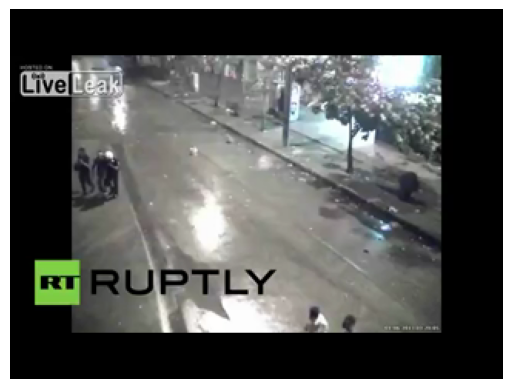

In [4]:
# original frame
print(f'original frame before resizing {numpy_array5[0].shape}') 
plt.imshow(numpy_array5[80]) #50, 200, 350, 500, 590 
plt.axis('off')  # Hide axes
plt.show()

In [5]:
img = Image.fromarray(numpy_array5[590])
img.save('refs/ref_fourth_5.png')

In [6]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

criterion = cross_entropy_for_onehot

Running on cpu


In [7]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [8]:
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
gt_data_single = tp(Image.fromarray(numpy_array5[0])).to('cpu')
gt_data_single = gt_data_single.view(1, *gt_data_single.size())
print(gt_data_single.shape)
gt_label = torch.Tensor([np.random.randint(1,100)]).long().to('cpu')
gt_label = gt_label.view(1, )
gt_onehot_label_single = label_to_onehot(gt_label, num_classes=100)
print(gt_onehot_label_single.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 100])


### Saving raw frames after transformation

In [15]:
import os
save_folder = "raw_frames_four_before_dlg"
os.makedirs(save_folder, exist_ok=True)

to_pil = transforms.transforms.ToPILImage()

for i, fr in enumerate(numpy_array5):
    raw_frame_tensor = tp(Image.fromarray(fr)).to('cpu')
    image = to_pil(raw_frame_tensor)  # Convert tensor to PIL image
    save_path = os.path.join(save_folder, f"image_{i}.png")  # Unique filename
    image.save(save_path)

### Continuation of ealier task

frame after resizing torch.Size([3, 32, 32])


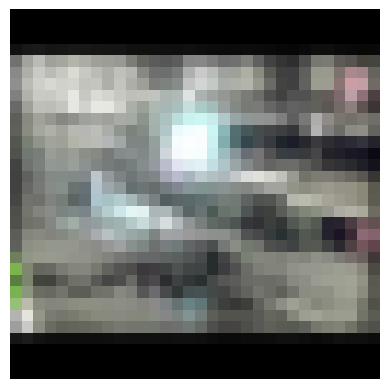

In [9]:
# resizing it for deep leakage limitations
print(f'frame after resizing {gt_data_single[0].shape}') 
img = gt_data_single[0].permute(1, 2, 0).cpu().numpy()
plt.imshow(img)
plt.axis('off') 
plt.show()

# Server side

In [10]:
all_gradients = []

for ind, item in enumerate(numpy_array5):
    gt_data = tp(Image.fromarray(numpy_array5[ind])).to('cpu')
    gt_data = gt_data.view(1, *gt_data.size())
    # print(gt_data.shape)
    gt_label = torch.Tensor([np.random.randint(1,100)]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=100)
    # print(gt_onehot_label.shape)

    out = net(gt_data)
    # print(out.shape)
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())
    
    
    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))
    all_gradients.append(original_dy_dx)
    

In [11]:
len(all_gradients)

601

In [12]:
def extract_data(index, original_dy_dx):
    print(f'working with frame {index+1}')
    count = 1
    current_loss = 999
    
    while(count <= 10):
        dummy_data = torch.randn(gt_data_single.size()).to(device).requires_grad_(True)
        dummy_label = torch.randn(gt_onehot_label_single.size()).to(device).requires_grad_(True)
        
        optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
        history = []
        for iters in range(300):
            def closure():
                optimizer.zero_grad()
        
                pred = net(dummy_data) 
                dummy_onehot_label = F.softmax(dummy_label, dim=-1)
                dummy_loss = criterion(pred, dummy_onehot_label) 
                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                
                grad_diff = 0
                grad_count = 0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
                    grad_diff += ((gx - gy) ** 2).sum()
                    grad_count += gx.nelement()
                grad_diff.backward()
                
                return grad_diff
            
            optimizer.step(closure)
            if iters == 299: 
                current_loss = closure()
                print(iters, "%.4f" % current_loss.item())
            history.append(dummy_data.cpu())
        count += 1
        if current_loss < 0.1:
            return history[-1]

In [13]:
extracted_data = []
for index, gradients in enumerate(all_gradients):
    extracted_data.append(extract_data(index, gradients))
    

working with frame 1
299 0.0000
working with frame 2
299 1801.5059
299 0.0000
working with frame 3
299 0.0000
working with frame 4
299 0.0000
working with frame 5
299 0.0000
working with frame 6
299 0.0000
working with frame 7
299 1051.0665
299 1365.3646
299 518.8788
299 0.0000
working with frame 8
299 0.0000
working with frame 9
299 380.0264
299 0.0000
working with frame 10
299 0.0000
working with frame 11
299 0.0000
working with frame 12
299 0.0000
working with frame 13
299 0.0000
working with frame 14
299 0.0000
working with frame 15
299 0.0000
working with frame 16
299 0.0000
working with frame 17
299 0.0000
working with frame 18
299 0.0000
working with frame 19
299 0.0000
working with frame 20
299 0.0000
working with frame 21
299 0.0000
working with frame 22
299 0.0000
working with frame 23
299 0.0000
working with frame 24
299 7.7086
299 0.0000
working with frame 25
299 0.0000
working with frame 26
299 0.0000
working with frame 27
299 0.0000
working with frame 28
299 0.0000
workin

In [14]:
print(extracted_data[0].shape)

torch.Size([1, 3, 32, 32])


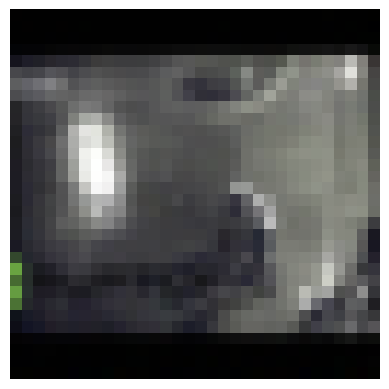

In [15]:
img = extracted_data[540][0].detach().permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
import av
import torch

frames = [_.squeeze(0) for _ in extracted_data]

# Define video parameters
output_file = "output_video_fifth.mp4"
fps = 30
frame_size = (32, 32)

container = av.open(output_file, mode='w')
stream = container.add_stream('mpeg4', rate=fps)
stream.width = frame_size[0]
stream.height = frame_size[1]
stream.pix_fmt = 'yuv420p'

for frame in frames:
    frame_np = frame.permute(1, 2, 0).detach().numpy()  # Shape: (32, 32, 3)
    frame_np = ((frame_np - frame_np.min()) / (frame_np.max() - frame_np.min()) * 255).astype('uint8')
    av_frame = av.VideoFrame.from_ndarray(frame_np, format='rgb24')
    for packet in stream.encode(av_frame):
        container.mux(packet)

for packet in stream.encode():
    container.mux(packet)
container.close()

print(f"Video saved to {output_file}")

Video saved to output_video_fourth.mp4
